In [1]:
import functools
import collections
import contextlib
from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
from jax import lax
from jax import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from tensorflow_probability.substrates.jax.internal.dtype_util
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfm = tfp.mcmc
tfed = tfp.experimental.distribute
tfde = tfp.experimental.distributions
tfem = tfp.experimental.mcmc

Root = tfed.JointDistributionCoroutine.Root
#matplotlib.use("Agg")  # noqa: E402

2022-11-29 14:14:33.537319: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/dkn16/local_package/lib/python3.7/site-packages/tensorrt/:/lib64/:/home/dkn16/tf/lib:/work/dkn16/local_package/lib/python3.7/site-packages/tensorrt/:/lib64/:/home/dkn16/tf/lib:/opt/gsl/2.6/lib
2022-11-29 14:14:33.537424: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /work/dkn16/local_package/lib/python3.7/site-packages/tensorrt/:/lib64/:/home/dkn16/tf/lib:/work/dkn16/local_package/lib/python3.7/site-packages/tensorrt/:/lib64/:/home/dkn16/tf/lib:/opt/gsl/2.6/lib
2022-11-29 14:14:33.537429: W tensorflow/compiler/tf2tensorrt/utils/py_uti

In [2]:

# create artificial regression dataset
def get_data(dim=128):
    #idx=np.random.randint(1,6)
    #loc_idx=np.random.randint(48)
    
    #foreground
    sky=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/sky/SKY_idx_1_loc_0.npy').astype(jnp.float64)[:,0:dim,0:dim].transpose(2,1,0)
    
    #HI signal
    cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64)[:,0:dim,0:dim].transpose(2,1,0)
    
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,150))/10000
    cosmos=cosmos.reshape((dim*dim,150))/10000
    np.random.seed(0)
    X = jnp.linspace(0., 1., sky.shape[1],dtype = jnp.float64)
    #Y = X + 0.2 * jnp.power(X, 3.0) + 0.5 * jnp.power(0.5 + X, 2.0) * jnp.sin(4.0 * X)
    #Y += sigma_obs * np.random.randn(N)
    #Y -= jnp.mean(Y)
    #Y /= jnp.std(Y)

    #assert X.shape == (N,)
    #assert Y.shape == (N,)

    X_test = jnp.linspace(0., 1.,sky.shape[1],dtype = jnp.float64)

    return X, sky+cosmos, X_test

In [18]:
def shard_value(x):
    x = x.reshape((jax.device_count(), -1, *x.shape[1:]))
    return jax.pmap(lambda x: x)(x) # pmap will physically place values on devices

shard = functools.partial(jax.tree_map, shard_value)
X, Y, X_test = get_data(250)

Y = shard(Y)
Y.shape

(4, 15625, 150)

In [11]:
#This is 'one parameter for all'

from jax.experimental.host_callback import call
dtype = jnp.float64
#@jax.default_matmul_precision('float32')
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, None,0), out_axes=(None,None))
def run(seed, X, data):
    #data = Y # a sharded dataset
    num_examples, dim = data.shape
    #num_classes = 10
    # this is our model 
    def kernel1(X, Z, var, length, noise, jitter=1.0e-12,is_noise=True):
        deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
        k = 10*var * jnp.exp(-0.5 * deltaXsq)
        #k = var * jnp.exp(-0.5 * deltaXsq)
        if is_noise:
            k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
        return k
    
    def model_fn():
        var = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        #print(var.shape
        noise = yield Root(tfd.Sample(tfd.HalfNormal(dtype(1.)), 1))
        length = yield Root(tfd.Sample(tfd.InverseGamma(dtype(10.),dtype(2.)), 1))
        #logits = jnp.dot(images, w) + b
        k =  jax.vmap(lambda var,length,noise: kernel1(X, X, var, length, noise))(var,length,noise)
        #print(k.shape)
        yield tfed.Sharded(tfd.MultivariateNormalFullCovariance(loc = jnp.zeros(dim,dtype=jnp.float64),covariance_matrix = k),
                           shard_axis_name='data')
    model = tfed.JointDistributionCoroutine(model_fn)

    init_seed, sample_seed = random.split(seed)

    initial_state = model.sample(seed=init_seed)[:-1] # throw away `y`

    def target_log_prob(*state):
        return model.log_prob((*state, data)).mean()

    #def accuracy(w, b):
    #    logits = images.dot(w) + b
    #    preds = logits.argmax(axis=-1)
        # We take the average accuracy across devices by using `lax.pmean`
    #    return lax.pmean((preds == labels).mean(), 'data')

    kernel = tfm.NoUTurnSampler(target_log_prob, 1e-2,max_tree_depth=8)
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel,500,target_accept_prob=0.8)
    def trace_fn(state, pkr):
        log_prob = target_log_prob(*state)
        call(lambda x: print(f"step: {x[0]},leap_frogs: {x[1]},step_size: {x[2]:.2g},accept_ratio:{x[3]:.3f},log_prob:{x[4]:.2f} \n "), (pkr.step,pkr.inner_results.leapfrogs_taken,pkr.new_step_size,10**pkr.inner_results.log_accept_ratio,log_prob))
        #call(lambda x: print(f"leap_frogs: {x}"), pkr.inner_results.leapfrogs_taken)
        #call(lambda x: print(f"step_size: {x}"), pkr.new_step_size)
        
        return (
            log_prob,
            pkr.inner_results.has_divergence,
            10**pkr.inner_results.log_accept_ratio,
            #accuracy(*state),
            pkr.new_step_size,
        )
    states, traces = tfm.sample_chain(
            num_results=1000,
            num_burnin_steps=1000,
            current_state=initial_state,
            kernel=kernel,
            trace_fn=trace_fn,
            seed=sample_seed,
        )
    return states, traces

In [19]:
from jax.experimental.host_callback import call
dtype = jnp.float64
#@jax.default_matmul_precision('float32')
@functools.partial(jax.pmap, axis_name='data', in_axes=(None, None,0), out_axes=(1,None))
def run(seed, X, data):
    #data = Y # a sharded dataset
    num_examples, dim = data.shape
    #num_classes = 10
    # this is our model 
    def kernel1(X, Z, var, length, noise, jitter=1.0e-12,is_noise=True):
        deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
        k = 10*var * jnp.exp(-0.5 * deltaXsq)
        #k = var * jnp.exp(-0.5 * deltaXsq)
        if is_noise:
            k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
        return k
    
    def model_fn():
        var = yield Root(tfd.Sample(tfed.Sharded(tfd.HalfNormal(dtype(1.),), shard_axis_name='data'),num_examples))
        #print(var.shape
        noise = yield Root(tfd.Sample(tfed.Sharded(tfd.HalfNormal(dtype(1.),), shard_axis_name='data'),num_examples))
        length = yield Root(tfd.Sample(tfed.Sharded(tfd.InverseGamma(dtype(10.),dtype(2.)), shard_axis_name='data'),num_examples))
        #logits = jnp.dot(images, w) + b
        k =  jax.vmap(lambda var,length,noise: kernel1(X, X, var, length, noise))(var,length,noise)
        #print(k.shape)
        yield tfed.Sharded(tfd.MultivariateNormalFullCovariance(loc = jnp.zeros((num_examples,dim),dtype=jnp.float64),covariance_matrix = k),
                           shard_axis_name='data')
    model = tfed.JointDistributionCoroutine(model_fn)

    init_seed, sample_seed = random.split(seed)

    initial_state = model.sample(seed=init_seed)[:-1] # throw away `y`

    def target_log_prob(*state):
        return model.log_prob((*state, data)).mean()

    #def accuracy(w, b):
    #    logits = images.dot(w) + b
    #    preds = logits.argmax(axis=-1)
        # We take the average accuracy across devices by using `lax.pmean`
    #    return lax.pmean((preds == labels).mean(), 'data')

    kernel = tfm.NoUTurnSampler(target_log_prob, 1e-2,max_tree_depth=8,experimental_shard_axis_names=["data","data","data"])
    kernel = tfm.DualAveragingStepSizeAdaptation(kernel,500)
    def trace_fn(state, pkr):
        log_prob = target_log_prob(*state)
        call(lambda x: print(f"step: {x[0]},leap_frogs: {x[1]},step_size: {x[2]:.2g},accept_ratio:{x[3]:.3f},log_prob:{x[4]:.2f} \n "), (pkr.step,pkr.inner_results.leapfrogs_taken,pkr.new_step_size,10**pkr.inner_results.log_accept_ratio,log_prob))
        #call(lambda x: print(f"leap_frogs: {x}"), pkr.inner_results.leapfrogs_taken)
        #call(lambda x: print(f"step_size: {x}"), pkr.new_step_size)
        
        return (
            log_prob,
            pkr.inner_results.has_divergence,
            10**pkr.inner_results.log_accept_ratio,
            #accuracy(*state),
            pkr.new_step_size,
        )
    states, traces = tfm.sample_chain(
            num_results=6,
            #num_burnin_steps=6,
            current_state=initial_state,
            kernel=kernel,
            trace_fn=trace_fn,
            seed=sample_seed,
        )
    return states, traces

In [20]:
%%time
states,trace = run(random.PRNGKey(42),X,Y)
#jnp.save('states.npy',states)

step: 0,leap_frogs: 0,step_size: 0.01,accept_ratio:1.000,log_prob:-22768.29 
 step: 0,leap_frogs: 0,step_size: 0.01,accept_ratio:1.000,log_prob:-22768.29 
 
step: 0,leap_frogs: 0,step_size: 0.01,accept_ratio:1.000,log_prob:-22768.29 
 
step: 0,leap_frogs: 0,step_size: 0.01,accept_ratio:1.000,log_prob:-22768.29 
 

step: 1,leap_frogs: 1,step_size: 0.026,accept_ratio:0.000,log_prob:-22768.29 
 
step: 1,leap_frogs: 1,step_size: 0.026,accept_ratio:0.000,log_prob:-22768.29 
 
step: 1,leap_frogs: 1,step_size: 0.026,accept_ratio:0.000,log_prob:-22768.29 
 
step: 1,leap_frogs: 1,step_size: 0.026,accept_ratio:0.000,log_prob:-22768.29 
 
step: 2,leap_frogs: 1,step_size: 0.0029,accept_ratio:0.000,log_prob:-22768.29 
 
step: 2,leap_frogs: 1,step_size: 0.0029,accept_ratio:0.000,log_prob:-22768.29 
 
step: 2,leap_frogs: 1,step_size: 0.0029,accept_ratio:0.000,log_prob:-22768.29 
 
step: 2,leap_frogs: 1,step_size: 0.0029,accept_ratio:0.000,log_prob:-22768.29 
 
step: 3,leap_frogs: 1,step_size: 0.00025

In [21]:
states = jnp.load('states.npy')
states[0][0]
# squared exponential kernel with diagonal noise term
def kernel(X, Z, var, length, noise, jitter=1.0e-12,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = 10*var * jnp.exp(-0.5 * deltaXsq)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k += (noise*noise*1.0e-10 + jitter) * jnp.eye(X.shape[0])
    return k

def predict(rng_key, X, Y, X_test, var, length, noise):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise,is_noise=False)
    k_pX = kernel(X_test, X, var, length, noise,is_noise=False)
    k_XX = kernel(X, X, var, length, noise,is_noise=True)
    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
    #sigma_noise = jnp.sqrt(jnp.clip(jnp.diag(K), a_min=0.0)) * jax.random.normal(
    #    rng_key, X_test.shape[:1]
    #)
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y.T)).T
    # we return both the mean function and a sample from the posterior predictive for the
    # given set of hyperparameters
    return mean#, mean + sigma_noise
vmap_args = (
    random.split(random.PRNGKey(3), 50),
    states[0][950:1000,0],
    states[2][950:1000,0],
    states[1][950:1000,0],
)
means = jax.vmap(
    lambda rng_key, var, length, noise: predict(
        rng_key, X, Y.reshape((-1,150)), X, var, length, noise
    )
)(*vmap_args)

mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(means, [5.0, 95.0], axis=0)

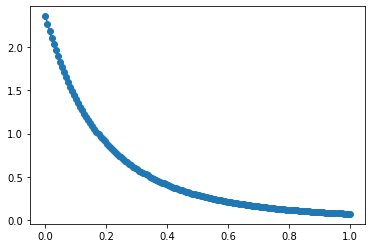

In [22]:
Y1=Y.reshape((-1,150))
plt.fill_between(X, percentiles[0, 100,:], percentiles[1, 100,:], color="lightblue")
plt.scatter(X,Y1[100])
plt.plot(X,mean_prediction[100])


In [7]:
cosmos=jnp.load(f'/work/dante/data/fg_rm_data/train_data/data_3/cosmos/HI_idx_1_loc_0.npy').astype(jnp.float64).transpose(2,1,0)
    
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(256*256,150)

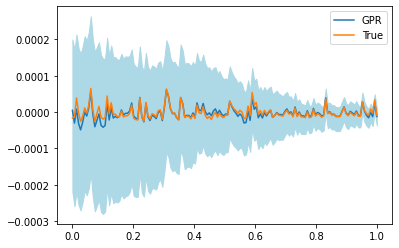

In [27]:
i=13550
plt.plot(X,Y1[i]-mean_prediction[i])

plt.plot(X,cosmos[i]/10000)
plt.fill_between(X_test,Y1[i]-percentiles[0, i,:], Y1[i]-percentiles[1, i,:], color="lightblue")
plt.legend(['GPR','True'])

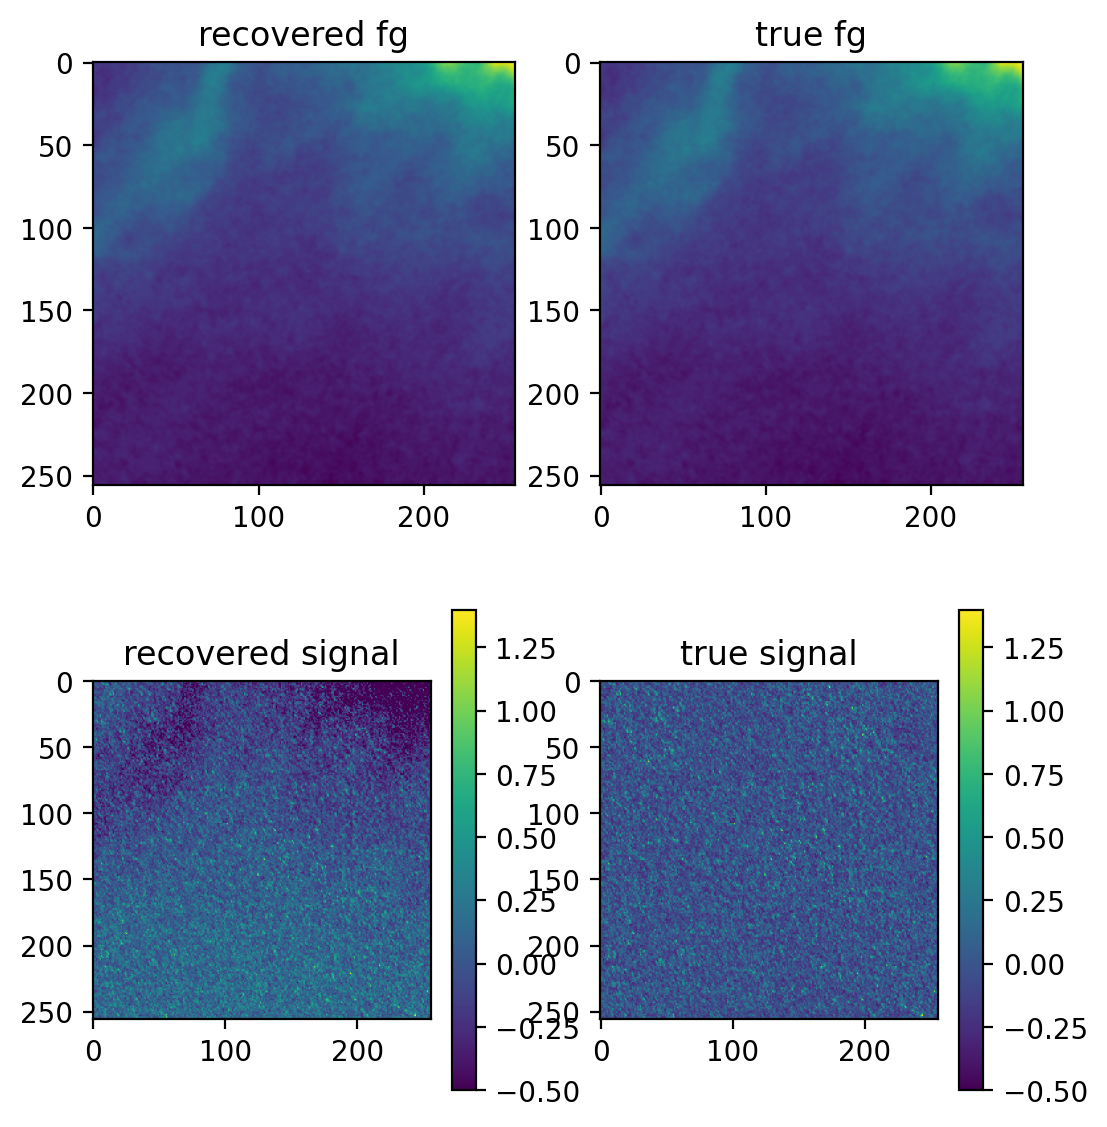

In [31]:
i=20
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_prediction[:,i].reshape(256,256))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y1[:,i].reshape(256,256))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y1[:,i]-mean_prediction[:,i]).reshape(256,256)*10000,vmin=-0.5,vmax=1.4)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(256,256),vmin=-0.5,vmax=1.4)
plt.title('true signal')
plt.colorbar()

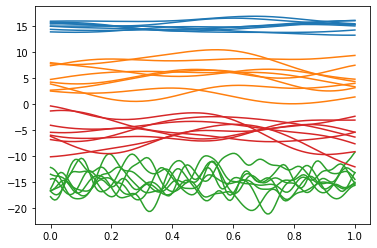

In [25]:
k1 = kernel(X, X,  0.052016747, 0.23297304, 1.81647456)
k2 = kernel(X, X,  1.52016747, 0.23297304, 1.81647456)
k3 = kernel(X, X,  0.52016747, 0.23297304, 1.81647456)
k4 = kernel(X, X,  0.52016747, 0.03297304, 1.81647456)
rng_key, rng_key_predict = random.split(random.PRNGKey(4))
samp = numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((2,2,X.shape[0])), covariance_matrix=[[k1,k2],[k3,k4]]),
        #obs=Y,
        rng_key= rng_key,sample_shape=(8,)
    )
for i in range(8):
    plt.plot(X,samp[i][0][0]+15,c='tab:blue')
    plt.plot(X,samp[i][1][0]+5,c='tab:orange')
    plt.plot(X,samp[i][0][1]-5,c='tab:red')
    plt.plot(X,samp[i][1][1]-15,c='tab:green')

In [160]:
numpyro.sample("kernel_var", dist.InverseGamma(10,2),rng_key= rng_key,sample_shape=(16,))

DeviceArray([0.16593575, 0.35661613, 0.44178466, 0.23166905, 0.19851243,
             0.26369422, 0.13496179, 0.21433583, 0.18115296, 0.14783476,
             0.28515543, 0.13975012, 0.13496239, 0.17410843, 0.21726044,
             0.12075873], dtype=float64)

In [30]:
percentiles.shape

(2, 10, 150)

In [125]:
Y.shape

(4096, 150)

In [110]:
k = kernel(X, X, 0.52016747, 0.23297304, 1.81647456)
jnp.mean(dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k).log_prob(Y))

DeviceArray(1264.82178955, dtype=float64)

In [170]:
samples

{'kernel_length': DeviceArray([0.42302552, 0.42301878, 0.42302362, 0.42301987, 0.42302611,
              0.42302386, 0.42301263, 0.42300984, 0.42300949, 0.42300693,
              0.42301815, 0.42301443, 0.42302797, 0.42303227, 0.42302964,
              0.4230277 , 0.42303511, 0.42303283, 0.42303401, 0.42303393,
              0.4230301 , 0.42302349, 0.42302522, 0.42302567, 0.42302858,
              0.42303519, 0.42303757, 0.42303275, 0.42303534, 0.42304212,
              0.42303208, 0.42303007, 0.42303806, 0.42303085, 0.42302919,
              0.42302831, 0.42302581, 0.42301978, 0.42301602, 0.42301501,
              0.42300887, 0.42299479, 0.42298329, 0.42298619, 0.42299007,
              0.42299533, 0.422989  , 0.42298821, 0.42299028, 0.42298966],            dtype=float64),
 'kernel_noise': DeviceArray([1.80610243, 1.80609536, 1.80603133, 1.80598893, 1.8059467 ,
              1.80592032, 1.8059154 , 1.80593716, 1.80591137, 1.80589166,
              1.80587565, 1.80587742, 1.80590157, 1

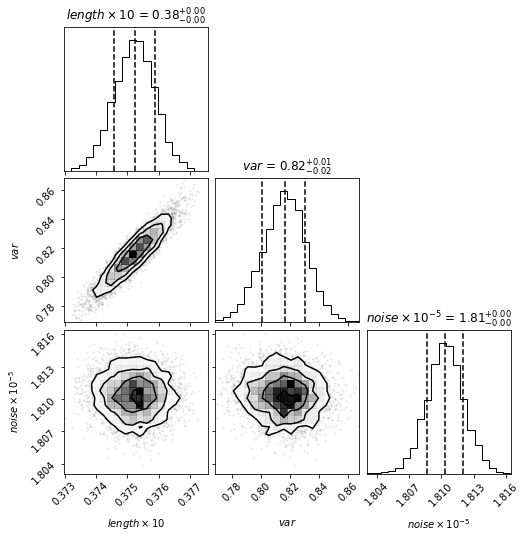

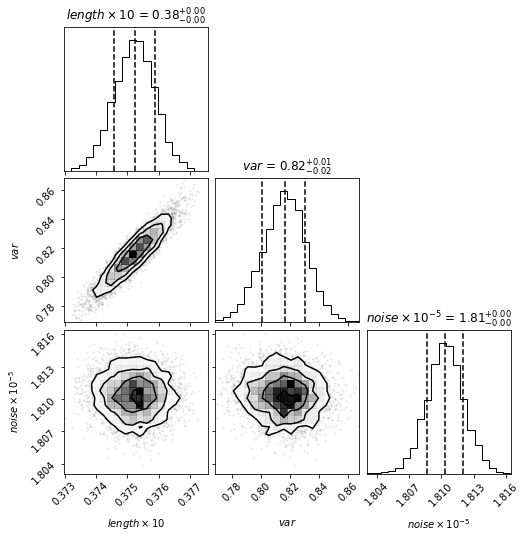

In [16]:
import corner
data = np.vstack([samples['kernel_length'],samples['kernel_var'],samples['kernel_noise']]).T
corner.corner(data,labels=[
        r"$length\times 10$",
        r"$var$",
        r"$noise\times 10^{-5}$",
    ],quantiles=[0.16, 0.5, 0.84],show_titles=True)

In [22]:
samp.shape

(8, 2, 2, 150)

In [21]:
Y.shape

(2, 2048, 150)